# Estudio sobre la Calidad del Vino

Este dataset fue tomado de Kaggle, https://www.kaggle.com/rajyellow46/wine-quality

Como información previa tenemos que:

The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

Attribute Information:

Input variables (based on physicochemical tests): 1 - fixed acidity 2 - volatile acidity 3 - citric acid 4 - residual sugar 5 - chlorides 6 - free sulfur dioxide 7 - total sulfur dioxide 8 - density 9 - pH 10 - sulphates 11 - alcohol

Output variable (based on sensory data): 12 - quality (score between 0 and 10)

Acknowledgements/Bibliography: [Cortez et al., 2009] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis, Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009. https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377

Acá un paper más nuevo: https://www.scitepress.org/Papers/2015/55519/55519.pdf

Acá, las unidades de los features:

The physicochemical data (input variables), and its corresponding statistics. The units are: FA: g(tartaric acid)/dm3; VA: g(acetic acid)/dm3; CA: g/dm3; RS: g/dm3; CH: g(sodium chloride)/dm3; FSD: mg/dm3; TSD: mg/dm3; DE: g/dm3; SU: g(potassium sulphate)/dm3; AL: %vol.

#### Nuestro objetivo es entrenar y aplicar algoritmos de Aprendizaje Automático para clasificar vinos a partir de sus características fisíco-químicas según un rango de clasificación definido a partir de la experiencia sensorial de la persona que lo cató.   

## Celdas preparatorias

In [1]:
# Cargo librerías 
import sys
import seaborn as sns
import numpy as np 
import random 
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import scatter_matrix
# Para realizar los gráficos debajo de la celda de código
%matplotlib inline

In [2]:
# Cargo librerías de sklearn
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
# Cargo los datos de entrenamiento

df_train = pd.read_csv('https://raw.githubusercontent.com/lupealvarez/TP_AA_UNSAM/main/winequalityN_train.csv')

df_test = pd.read_csv('https://raw.githubusercontent.com/lupealvarez/TP_AA_UNSAM/main/winequalityN_test.csv')

## Preprocesamiento 
Exploramos los datos rápidamente, completamos los datos faltanes, transformamos las variables categóricas y quitamos los outliers. 

In [128]:
# Exploramos rápidamente
df_train.head(10)

,vino_num,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,702,white,6.6,0.38,0.18,1.20,0.042,20.0,84.0,0.99270,3.22,0.45,10.1,4
1,1021,white,8.6,0.20,0.42,1.50,0.041,35.0,125.0,0.99250,3.11,0.49,11.4,7
2,4691,white,6.9,0.19,0.31,19.25,0.043,38.0,167.0,0.99954,2.93,0.52,9.1,7
3,1623,white,7.0,0.14,0.49,5.90,0.053,22.0,118.0,0.99540,3.36,0.36,9.4,6
4,5848,red,8.9,0.12,0.45,1.80,0.075,10.0,21.0,0.99552,3.41,0.76,11.9,7
5,696,white,6.7,0.19,0.34,1.00,0.022,22.0,94.0,0.99120,3.23,0.57,11.1,6
6,1562,white,7.1,0.34,0.49,1.50,0.027,26.0,126.0,0.99000,3.30,0.33,12.2,7
7,1015,white,7.6,0.39,0.22,2.80,0.036,19.0,113.0,0.99260,3.03,0.29,10.2,5
8,2515,white,7.1,0.12,0.30,3.10,0.018,15.0,37.0,0.99004,3.02,0.52,11.9,7
9,4252,white,6.7,0.11,0.26,14.80,0.053,44.0,95.0,0.99676,3.20,0.35,9.8,6


In [129]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vino_num              5197 non-null   int64  
 1   type                  5197 non-null   object 
 2   fixed acidity         5188 non-null   float64
 3   volatile acidity      5190 non-null   float64
 4   citric acid           5195 non-null   float64
 5   residual sugar        5196 non-null   float64
 6   chlorides             5197 non-null   float64
 7   free sulfur dioxide   5197 non-null   float64
 8   total sulfur dioxide  5197 non-null   float64
 9   density               5197 non-null   float64
 10  pH                    5191 non-null   float64
 11  sulphates             5193 non-null   float64
 12  alcohol               5197 non-null   float64
 13  quality               5197 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 568.5+ KB


 Data frame de 14 columnas y 5197 filas.  
1 columna de tipo string y 12 de tipo punto flotante .  
Nuestro target será la calidad del vino -> interger (score between 0 and 10, being 10 de best quality).  
El set de entrenamiento recibido tiene una columna más. Asumo que es el número de medición en el data set original.  
Para separar el data set original en train y test, se realizó una división estratificada según la calidad.  

In [130]:
# La cambio el nombre a la columna "Unnamed"
df_train.rename(columns={'Unnamed: 0':'vino_num'}, inplace=True)

df_test.rename(columns={'Unnamed: 0':'vino_num'}, inplace=True)

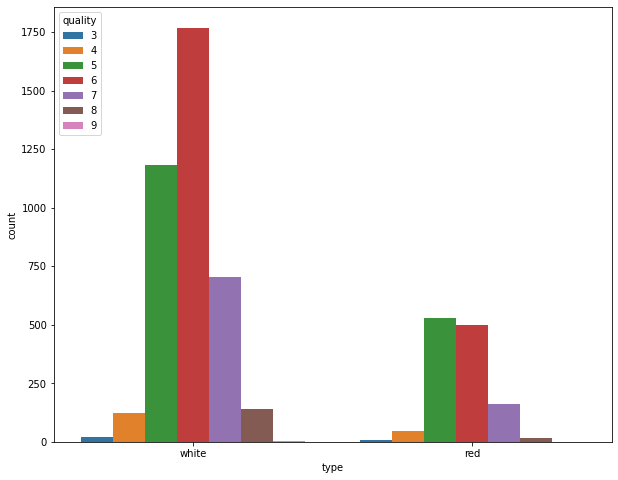

In [131]:
plt.figure(figsize=(10,8))
sns.countplot(x='type',hue='quality',data=df_train);

In [132]:
df_train['quality'].value_counts() 

6    2269
5    1710
7     863
4     169
8     154
3      28
9       4
Name: quality, dtype: int64

El data set se encuentra muy desbalanceado respecto las categorías de calidad. Hay muy pocas observaciones de calidad 3 y de calidad 9.  
Decidimos combinar estas categorías poco representadas, por un lado, la 3 con la 4 y por el otro lado, la 8 con la 9.  
También hay un desbalance respecto el tipo de vino (blanco y tinto). 

In [133]:
# Hacemos una copia primero, para no modificar el data set original.
df = df_train.copy()

# Juntemos los datos en tres categorías de calidad y Renombremos las categorías
#df['quality'] = df['quality'].map({3:3, 4:3, 5:3, 6:2, 7:1, 8:1, 9:1})
df['quality'] = df['quality'].map({3:2, 4:2, 5:2, 6:1, 7:0, 8:0, 9:0})


# ¿Ó 7 ya sería medio pelo?

In [134]:
# Hacemos una copia primero, para no modificar el data set original.
df_t = df_test.copy()

# Juntemos los datos en tres categorías de calidad y Renombremos las categorías
#df_t['quality'] = df_t['quality'].map({3:2, 4:2, 5:2, 6:1, 7:0, 8:0, 9:0})

df_t['quality'] = df_t['quality'].map({3:3, 4:3, 5:3, 6:2, 7:1, 8:1, 9:1})



In [135]:
# Veamos si se realizó el cambio
df['quality'].value_counts() 

1    2269
2    1907
0    1021
Name: quality, dtype: int64

Tenemos entonces tres categorias de calidad de vino:   
1 = Bueno  
2 = Medio pelo   
3 = Berretón   



In [136]:
# Transformamos la variable categórica "type" en numérica 
df['type'] = df['type'].map({'white': 0, 'red': 1})

df_t['type'] = df_t['type'].map({'white': 0, 'red': 1})

Tipo de vino:  
0 = vino blanco  
1 = vino tinto  

In [137]:
df.head(10)

,vino_num,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,702,0,6.6,0.38,0.18,1.20,0.042,20.0,84.0,0.99270,3.22,0.45,10.1,2
1,1021,0,8.6,0.20,0.42,1.50,0.041,35.0,125.0,0.99250,3.11,0.49,11.4,0
2,4691,0,6.9,0.19,0.31,19.25,0.043,38.0,167.0,0.99954,2.93,0.52,9.1,0
3,1623,0,7.0,0.14,0.49,5.90,0.053,22.0,118.0,0.99540,3.36,0.36,9.4,1
4,5848,1,8.9,0.12,0.45,1.80,0.075,10.0,21.0,0.99552,3.41,0.76,11.9,0
5,696,0,6.7,0.19,0.34,1.00,0.022,22.0,94.0,0.99120,3.23,0.57,11.1,1
6,1562,0,7.1,0.34,0.49,1.50,0.027,26.0,126.0,0.99000,3.30,0.33,12.2,0
7,1015,0,7.6,0.39,0.22,2.80,0.036,19.0,113.0,0.99260,3.03,0.29,10.2,2
8,2515,0,7.1,0.12,0.30,3.10,0.018,15.0,37.0,0.99004,3.02,0.52,11.9,0
9,4252,0,6.7,0.11,0.26,14.80,0.053,44.0,95.0,0.99676,3.20,0.35,9.8,1


In [138]:
df.shape

(5197, 14)

 Separemos el target "quality" de los features.

In [139]:
# Separamos las etiquetas (el target)
df_labels = df["quality"].copy()

# Separamos los features (quitamos el target)
df = df.drop("quality", axis=1) # drop labels for training set
df = df.drop("vino_num", axis=1) # drop vino_num for training set

# Separamos los features numéricos
df_num = df.drop("type", axis=1)

In [140]:
# Separamos las etiquetas (el target)
df_t_labels = df_t["quality"].copy()

# Separamos los features (quitamos el target)
df_t = df_t.drop("quality", axis=1) # drop labels for training set
df_t = df_t.drop("vino_num", axis=1) # drop vino_num for training set

# Separamos los features numéricos
df_t_num = df_t.drop("type", axis=1)

In [141]:
df_num.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.6,0.38,0.18,1.20,0.042,20.0,84.0,0.99270,3.22,0.45,10.1
1,8.6,0.20,0.42,1.50,0.041,35.0,125.0,0.99250,3.11,0.49,11.4
2,6.9,0.19,0.31,19.25,0.043,38.0,167.0,0.99954,2.93,0.52,9.1
3,7.0,0.14,0.49,5.90,0.053,22.0,118.0,0.99540,3.36,0.36,9.4
4,8.9,0.12,0.45,1.80,0.075,10.0,21.0,0.99552,3.41,0.76,11.9
5,6.7,0.19,0.34,1.00,0.022,22.0,94.0,0.99120,3.23,0.57,11.1
6,7.1,0.34,0.49,1.50,0.027,26.0,126.0,0.99000,3.30,0.33,12.2
7,7.6,0.39,0.22,2.80,0.036,19.0,113.0,0.99260,3.03,0.29,10.2
8,7.1,0.12,0.30,3.10,0.018,15.0,37.0,0.99004,3.02,0.52,11.9
9,6.7,0.11,0.26,14.80,0.053,44.0,95.0,0.99676,3.20,0.35,9.8


In [142]:
df.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0,6.6,0.38,0.18,1.20,0.042,20.0,84.0,0.99270,3.22,0.45,10.1
1,0,8.6,0.20,0.42,1.50,0.041,35.0,125.0,0.99250,3.11,0.49,11.4
2,0,6.9,0.19,0.31,19.25,0.043,38.0,167.0,0.99954,2.93,0.52,9.1
3,0,7.0,0.14,0.49,5.90,0.053,22.0,118.0,0.99540,3.36,0.36,9.4
4,1,8.9,0.12,0.45,1.80,0.075,10.0,21.0,0.99552,3.41,0.76,11.9
5,0,6.7,0.19,0.34,1.00,0.022,22.0,94.0,0.99120,3.23,0.57,11.1
6,0,7.1,0.34,0.49,1.50,0.027,26.0,126.0,0.99000,3.30,0.33,12.2
7,0,7.6,0.39,0.22,2.80,0.036,19.0,113.0,0.99260,3.03,0.29,10.2
8,0,7.1,0.12,0.30,3.10,0.018,15.0,37.0,0.99004,3.02,0.52,11.9
9,0,6.7,0.11,0.26,14.80,0.053,44.0,95.0,0.99676,3.20,0.35,9.8


Ahora, aplicamos un pipeline para completar los datos faltantes y estandarizar los datos numéricos 

In [143]:
# Creamos un pipeline numerico, que hace dos acciones consecutivas: primero rellena
#los valores faltantes (con SimpleImputer) y despues estandariza (con StandardScaler)
#lo bueno es que se lo pasas a todas las columnas numericas, no una por una como antes

num_pipeline = Pipeline([  
        ('imputer', SimpleImputer(strategy="median")), 
        ('std_scaler', StandardScaler()),
    ])


In [144]:
# Trnasformamos train
df_num_transformed = num_pipeline.fit_transform(df_num)     # Aplicamos el pipeline
df_transformed = np.column_stack((df_num_transformed, df["type"]))  # Agregamos la columna categórica al data frame transformado. 

In [145]:
# Transformamos test
df_t_num_transformed = num_pipeline.fit_transform(df_t_num)     # Aplicamos el pipeline
df_t_transformed = np.column_stack((df_t_num_transformed, df_t["type"]))  # Agregamos la columna categórica al data frame transformado. 

In [146]:
df_t_transformed.shape

(1300, 12)

In [147]:
df_transformed[1, ]

array([ 1.0732888 , -0.83903899,  0.69157446, -0.82528233, -0.42165037,
        0.26087934,  0.15848305, -0.72232142, -0.66715418, -0.27321879,
        0.75459576,  0.        ])

Hagamos una análisis de PCA para poder observar los datos.  

In [148]:
# Aplicamos PCA para ver los datos
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(df_transformed)

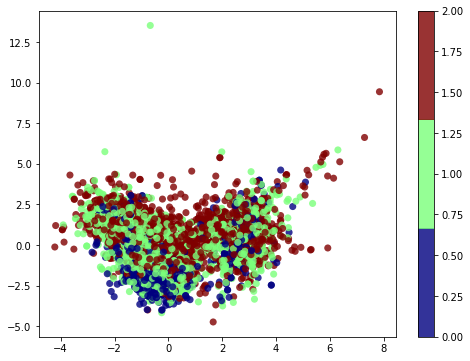

In [149]:
#Graficamos custom CMAP
t = df_labels 
from matplotlib import cm
cmap = cm.get_cmap('jet', 3) 

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scat = ax.scatter(*X_2d.T, c=t, s=50, cmap=cmap, 
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat);

Apliquemos un método para la detección y remoción de outliers.   
Elijo el método **LocalOutlierFactor** que se basa en la distancia entre un punto y sus vecinos.  

In [150]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()

preds_otliers = lof.fit_predict(df_transformed)

preds_t_otliers = lof.fit_predict(df_t_transformed)

In [151]:
LocalOutlierFactor?

In [152]:
X_outliers = df_transformed[preds_otliers == -1]
X_valid = df_transformed[preds_otliers != -1]
mask = preds_otliers != -1

In [153]:
X_t_outliers = df_t_transformed[preds_t_otliers == -1]
X_t_valid = df_t_transformed[preds_t_otliers != -1]
mask_t = preds_t_otliers != -1

In [154]:
X_t_valid.shape, X_t_outliers.shape

((1248, 12), (52, 12))

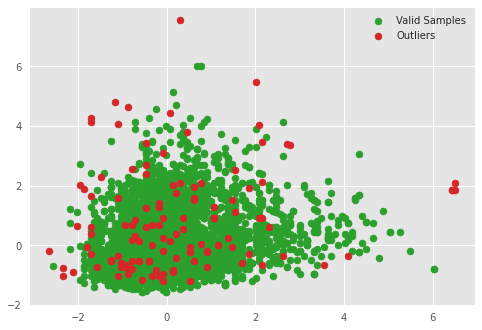

In [155]:
def plot_outliers_with_valid_samples(X_valid, X_outliers):
    with plt.style.context(("seaborn", "ggplot")):
        plt.scatter(X_valid[:, 0], X_valid[:, 1], c="tab:green", label="Valid Samples")
        plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="tab:red", label="Outliers")
        plt.legend(loc="best")
plot_outliers_with_valid_samples(X_valid, X_outliers)

Nos quedamos con los datos clasisificados como **válidos**. Con estos ya separamos los datos en _features_ y _target_ para la aplicación de modelos. 

In [156]:
X_train, t_train =  df_transformed[mask, :], df_labels[mask]

In [157]:
X_test, t_test =  df_t_transformed[mask_t, :], df_t_labels[mask_t]

In [158]:
X_train.shape, t_train.shape, X_train.shape, t_train.shape

((5077, 12), (5077,), (5077, 12), (5077,))

In [159]:
X_train[1,]

array([ 1.0732888 , -0.83903899,  0.69157446, -0.82528233, -0.42165037,
        0.26087934,  0.15848305, -0.72232142, -0.66715418, -0.27321879,
        0.75459576,  0.        ])

In [160]:
t_train.value_counts() 

1    2224
2    1843
0    1010
Name: quality, dtype: int64

Aplicamos PCA otra vez para observar los datos.  

In [161]:
x_valid_2d = pca.fit_transform(X_train)

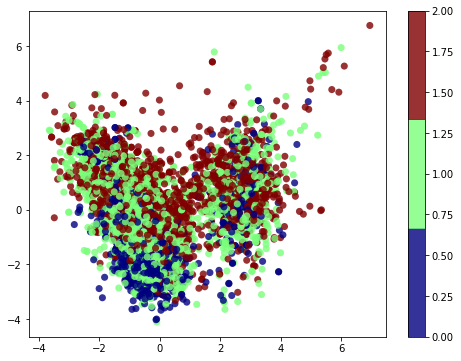

In [162]:
t = t_train 
from matplotlib import cm
cmap = cm.get_cmap('jet', 3) 

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scat = ax.scatter(*x_valid_2d.T, c=t, s=50, cmap=cmap, 
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat);

In [163]:
# Veamos cuántos PC necesitaríamos para explicar al menos el 90% de la varianza de los datos
pca_libre = PCA()
X_pca = pca_libre.fit_transform(X_train)

In [164]:
print('Porcentaje de varianza:', pca_libre.explained_variance_ratio_)

print('Porcentaje de varianza acumulada:', pca_libre.explained_variance_ratio_.cumsum())

Porcentaje de varianza: [0.28590124 0.22674007 0.14068607 0.08678719 0.0629733  0.05414186
 0.04419507 0.04262523 0.02949672 0.02110269 0.00410227 0.0012483 ]
Porcentaje de varianza acumulada: [0.28590124 0.51264131 0.65332738 0.74011457 0.80308787 0.85722973
 0.9014248  0.94405003 0.97354674 0.99464943 0.9987517  1.        ]


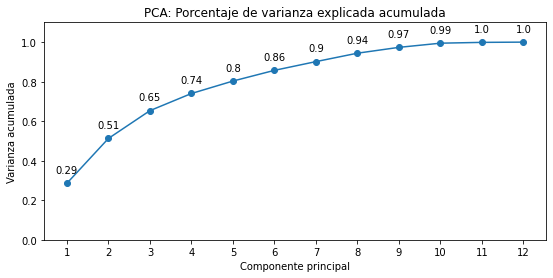

In [165]:
# Graficamos la varianza acumulada vs PC
prop_varianza_acum = pca_libre.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.plot(
    np.arange(pca_libre.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(pca_libre.n_components_) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

#ax.axvline(x=11, linestyle = '--')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca_libre.n_components_) + 1)
ax.set_title('PCA: Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Varianza acumulada');

## Ahora si...pasemos a la clasificación!!!

# Regresor Logístico

Probemos un Regresor Logístico como Modelo de Base.  

In [42]:
# Importamos funciones de sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [ ]:
LogisticRegression?

In [ ]:
lr = LogisticRegression(random_state=42) 

In [ ]:
lr_predic = cross_val_predict(lr,  X_train, t_train, cv = 5)

In [ ]:
cm_lr = confusion_matrix(t_train, lr_predic)
print(cm_lr)

[[ 345  588   77]
 [ 242 1422  560]
 [  28  636 1179]]


In [ ]:
# Defino una función para graficar la matriz de confusion
def graficar_matriz_confusion(cm, true_labels):
  df_cm = pd.DataFrame(cm, columns=np.unique(true_labels), index=np.unique(true_labels))
  df_cm.index.name = 'Etiqueta'
  df_cm.columns.name = 'Predicción'

  ax= plt.subplot()
  sns.heatmap(df_cm, annot=True, fmt='g', ax=ax, cmap="viridis")
  plt.title('Matriz de Confusión')
  plt.show()

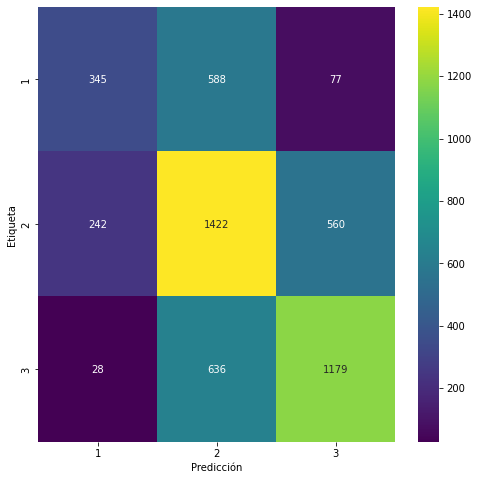

In [ ]:
# Graficamos la matriz de confusion
graficar_matriz_confusion(cm_lr, t_train)

Observamos que las clases 2 y 3 tienen mayor cantidad de TP que la clase 1.  Esto no es sorprendente pues son las clases más pobladas. Sin embargo, la clase 2 es la peor clasificada, dada la mayor tasa de FP en esta clase.
  

In [ ]:
scores_lr = cross_validate(lr, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))
#print(scores_lr)

In [ ]:
accuracy = scores_lr['test_accuracy']
f1_macro = scores_lr['test_f1_macro']
recall_macro = scores_lr['test_recall_macro']
precision_macro = scores_lr['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.580 +/- 0.011
f1 macro: 0.551 +/- 0.009
Recall macro: 0.540 +/- 0.010
Precision macro: 0.583 +/- 0.010


In [43]:
# Defino una función para calcular la curva ROC de cada clase (adaptada de StackOverflow). 
# Se basa en el método de "One vs all"

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

def curvas_roc_one_vs_rest(n_clases, nom_clases, true_labels, y_score):
  # Binarizamos las etiquetas 
  y = label_binarize(true_labels, classes=nom_clases)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
  colors = cycle(['red','yellowgreen','turquoise'])
  for i, color in zip(range(n_clases), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=3,
             label='Curva ROC clase {0} (AUC = {1:2.2%})'
             ''.format(i+1, roc_auc[i]))
  plt.plot([0, 1], [0, 1], color='0.5', ls=':')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Tasa de falsos positivos (FPR)')
  plt.ylabel('Tasa de verdaderos positivos (TPR)')
  plt.title('Curvas ROC por clase (One-vs-Rest)')
  plt.legend(loc="lower right")
  plt.show()

In [44]:
# También podemos graficar una curva ROC "promedio"
def curva_roc_promedio_macro(n_clases, nom_clases, true_labels, y_score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  #Binarizamos las etiquetas

  y_labels = label_binarize(true_labels, classes=nom_clases)
                          
  for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Calculamos la curva ROC promedio-macro y la AUC 
        # Se juntan todos los FP 
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_clases)]))
        # Se interpolan todas las curvas ROC
  mean_tpr = np.zeros_like(all_fpr)
                          
  for i in range(n_clases):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        # Se promedia y se calcula la AUC
  mean_tpr /= n_clases
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  plt.plot(fpr["macro"], tpr["macro"], label='AUC = {0:2.2%}'
                       ''.format(roc_auc["macro"]), linewidth=3)
  plt.plot([0, 1], [0, 1], color='0.5', ls=':')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Tasa de falsos positivos (FPR)')
  plt.ylabel('Tasa de verdaderos positivos (TPR)')
  plt.title('Curva ROC promedio-macro')
  plt.legend(loc="lower right")
  plt.show()

In [45]:

def curvas_roc_multiclase(n_clases, nom_clases, true_labels, y_score):
  # Binarizamos las etiquetas 
  y = label_binarize(true_labels, classes=nom_clases)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

   # Calculamos la curva ROC promedio-macro y la AUC 
        # Se juntan todos los FP 
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_clases)]))
        # Se interpolan todas las curvas ROC
  mean_tpr = np.zeros_like(all_fpr)
                          
  for i in range(n_clases):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        # Se promedia y se calcula la AUC
  mean_tpr /= n_clases
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
  colors = cycle(['red','yellowgreen','turquoise'])
  for i, color in zip(range(n_clases), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=3,
             label='Curva ROC clase {0} (AUC = {1:2.2%})'
             ''.format(i+1, roc_auc[i]))
  
  plt.plot(fpr["macro"], tpr["macro"], linewidth=3, color = 'black', label='Promedio-macro (AUC = {0:2.2%})'
                       ''.format(roc_auc["macro"]))
  plt.plot([0, 1], [0, 1], color='0.5', ls=':')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Tasa de falsos positivos (FPR)')
  plt.ylabel('Tasa de verdaderos positivos (TPR)')
  plt.title('Curvas ROC')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
y_score_lr = cross_val_predict(lr, X_train, t_train, cv = 5, method = "predict_proba")

In [46]:
n_clases = 3
nom_clases = [1, 2, 3]

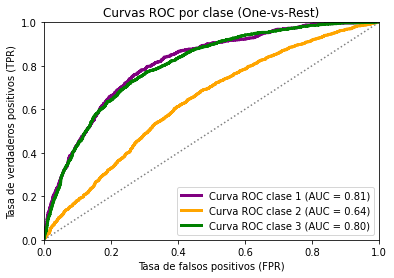

In [ ]:
# Graficamos la curva ROC 

curvas_roc_one_vs_rest(n_clases=n_clases, nom_clases=nom_clases, true_labels=t_train, y_score=y_score_lr)

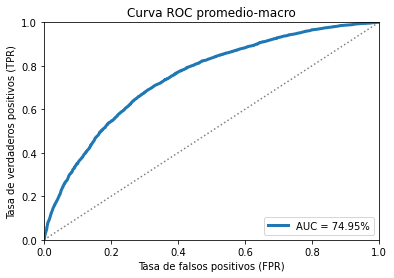

In [ ]:
curva_roc_promedio_macro(n_clases=n_clases, nom_clases=nom_clases, true_labels=t_train, y_score=y_score_lr)

Ajustemos las perillas del Regresor Logístico con GridSearchCV.   


In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params_lr = {'penalty' : ['l2', 'l1'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg', 'sag', 'lbfgs'],
    'max_iter': [200, 250, 300],
    'tol' : [0.001, 0.0001], 
    'multi_class' : ['ovr', 'multinomial']}

grilla_lr = GridSearchCV(lr, params_lr, cv = 5, scoring = "accuracy")

grilla_lr.fit(X_train, t_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 2.636...
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [200, 250, 300],
                         'multi_class': ['ovr', 'multinomial'],
                         'pena

In [ ]:
grilla_lr.best_params_

{'C': 11.288378916846883,
 'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.001}

In [ ]:
grilla_lr.best_estimator_

LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=42, solver='newton-cg', tol=0.001,
                   verbose=0, warm_start=False)

In [ ]:
lr_best_model = grilla_lr.best_estimator_
predicts_lr_best = cross_val_predict(lr_best_model, X_train, t_train, cv=5)
scores_lr_best = cross_validate(lr_best_model, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))

In [ ]:
cm_lr_best = confusion_matrix(t_train, predicts_lr_best)
print(cm_lr_best)

[[ 350  583   77]
 [ 239 1427  558]
 [  28  635 1180]]


In [ ]:
accuracy = scores_lr_best['test_accuracy']
f1_macro = scores_lr_best['test_f1_macro']
recall_macro = scores_lr_best['test_recall_macro']
precision_macro = scores_lr_best['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.582 +/- 0.011
f1 macro: 0.554 +/- 0.009
Recall macro: 0.543 +/- 0.010
Precision macro: 0.586 +/- 0.010


In [ ]:
y_score_lr_best = cross_val_predict(lr_best_model, X_train, t_train, cv = 5, method = "predict_proba")

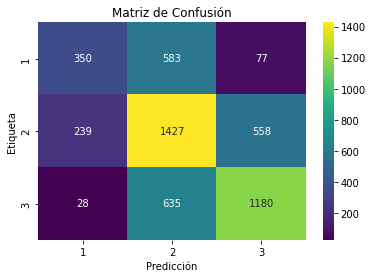

In [ ]:
graficar_matriz_confusion(cm_lr_best, t_train)

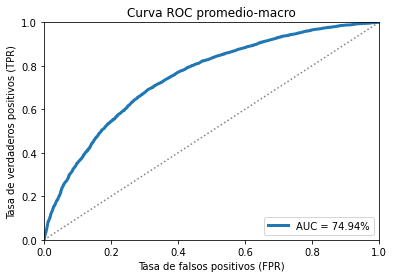

In [ ]:
curva_roc_promedio_macro(n_clases=n_clases, nom_clases=nom_clases, true_labels=t_train, y_score=y_score_lr_best)

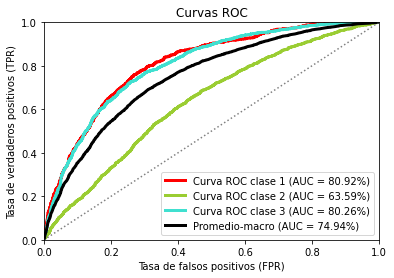

In [ ]:
curvas_roc_multiclase(n_clases=n_clases, nom_clases=nom_clases, true_labels=t_train, y_score=y_score_lr_best)

# Árbol de decisión

In [49]:
from sklearn.tree import DecisionTreeClassifier



In [ ]:
DecisionTreeClassifier?

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt_predic = cross_val_predict(dt, X_train, t_train, cv = 5)

In [ ]:
cm_dt = confusion_matrix(t_train, dt_predic)
print(cm_dt)

[[ 603  321   86]
 [ 362 1355  507]
 [  89  542 1212]]


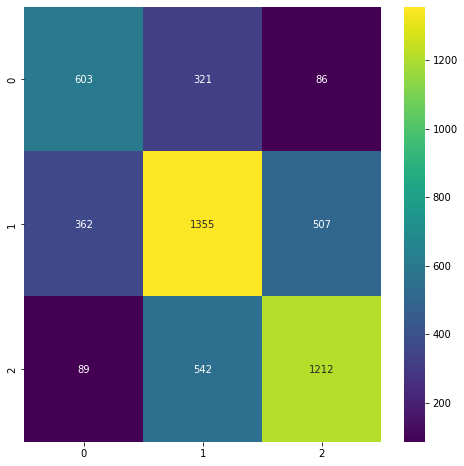

In [ ]:
# Graficamos la matriz de confusion
plt.figure(figsize= (8, 8))
ax= plt.subplot()
sns.heatmap(cm_dt, annot=True, fmt='g', ax=ax, cmap="viridis");

El Decision Tree clasifica mejor la clase 1 que el LR.   
Veamos las métricas:

In [ ]:
scores_dt = cross_validate(dt, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))
#print(scores_dt)

In [ ]:
accuracy = scores_dt['test_accuracy']
f1_macro = scores_dt['test_f1_macro']
recall_macro = scores_dt['test_recall_macro']
precision_macro = scores_dt['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.624 +/- 0.010
f1 macro: 0.619 +/- 0.009
Recall macro: 0.621 +/- 0.009
Precision macro: 0.618 +/- 0.010


Ajustemos perillas!!!

In [ ]:
#params={'max_depth':[2, 3, 5],'min_samples_leaf':[10,50], 'max_leaf_nodes':[3,4,5]}
tree_param = [{'criterion': ['gini', 'entropy'],
              'max_depth': [6,8,10,12],
              'min_samples_leaf': [40, 50, 60],
              'max_leaf_nodes': [35, 40, 45]}]
grilla_dt = GridSearchCV(dt, tree_param, cv=5, scoring='accuracy')
grilla_dt.fit(X_train, t_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['gini', 'entropy'],
                    

In [ ]:
grilla_dt.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_leaf_nodes': 45,
 'min_samples_leaf': 40}

In [ ]:
model_dt = grilla_dt.best_estimator_

In [ ]:
scores_dt = cross_validate(model_dt, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))


In [ ]:
dt_predic = cross_val_predict(model_dt, X_train, t_train, cv = 5)

In [ ]:
cm_dtOpt = confusion_matrix(t_train, dt_predic)
print(cm_dtOpt)

[[ 399  521   90]
 [ 267 1352  605]
 [  48  611 1184]]


In [ ]:
accuracy = scores_dt['test_accuracy']
f1_macro = scores_dt['test_f1_macro']
recall_macro = scores_dt['test_recall_macro']
precision_macro = scores_dt['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.578 +/- 0.015
f1 macro: 0.557 +/- 0.019
Recall macro: 0.548 +/- 0.019
Precision macro: 0.581 +/- 0.022


El modelo "optimizado" da peores *scores* que el no optimizado... 

# SVM

**Creo que está mal implementado. Para el caso multiclase debería ser LinearSVM ( multi_class = 'crammer_singer')**

In [ ]:
from sklearn.svm import SVC
svc = SVC(random_state=42, probability=True)     

In [ ]:
X_train.dtype

dtype('float64')

In [ ]:
svc_predic = cross_val_predict(svc, X_train, t_train, cv = 5)

In [ ]:
cm_svc = confusion_matrix(t_train, svc_predic)
print(cm_svc)

[[ 356  614   40]
 [ 182 1515  527]
 [  18  581 1244]]


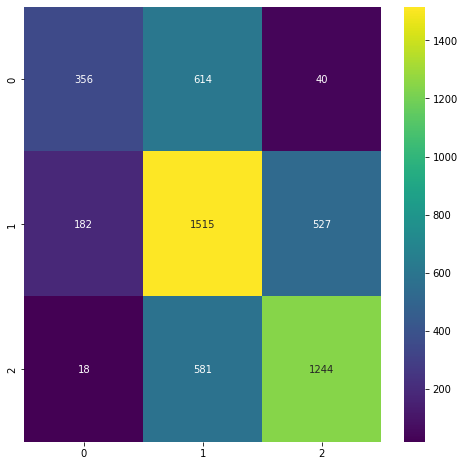

In [ ]:
# Graficamos la matriz de confusion
plt.figure(figsize= (8, 8))
ax= plt.subplot()
sns.heatmap(cm_svc, annot=True, fmt='g', ax=ax, cmap="viridis");

In [ ]:
scores_svc = cross_validate(svc, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))

accuracy = scores_svc['test_accuracy']
f1_macro = scores_svc['test_f1_macro']
recall_macro = scores_svc['test_recall_macro']
precision_macro = scores_svc['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.614 +/- 0.009
f1 macro: 0.583 +/- 0.009
Recall macro: 0.570 +/- 0.009
Precision macro: 0.630 +/- 0.014


Ajustemos perillas!!!

In [ ]:
tree_param = [{ 'C':[0.1,1,100],'kernel':['rbf','poly','sigmoid'],'degree':[1,2,3],'gamma': [1, 0.1, 0.01, 0.001]}]
grilla_svm = RandomizedSearchCV(svc, tree_param, cv=5, n_iter = 20, scoring='accuracy')
grilla_svm.fit(X_train, t_train)


In [ ]:
model_svm = grilla_svm.best_estimator_

In [ ]:
scores_svm = cross_validate(model_svm, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))


In [ ]:
svm_predic = cross_val_predict(model_svm, X_train, t_train, cv = 5)

In [ ]:
cm_svmOpt = confusion_matrix(t_train, svm_predic)
print(cm_svmOpt)

In [ ]:
accuracy = scores_svm['test_accuracy']
f1_macro = scores_svm['test_f1_macro']
recall_macro = scores_svm['test_recall_macro']
precision_macro = scores_svm['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

#KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
kn_clf =  KNeighborsClassifier()  

In [ ]:
params_kn = {
    'n_neighbors' :[15,19, 20, 22,24,26],
    'weights':['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}
grilla_kn = GridSearchCV(kn_clf, params_kn, cv=5, scoring='accuracy')
grilla_kn.fit(X_train, t_train)

In [ ]:
model_kn = grilla_kn.best_estimator_

In [ ]:
scores_knOpt = cross_validate(model_kn, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))

In [ ]:
knOpt_predic = cross_val_predict(model_kn, X_train, t_train, cv = 5)

In [ ]:
cm_knOpt = confusion_matrix(t_train, knOpt_predic)
print(cm_knOpt)

In [ ]:
graficar_matriz_confusion(cm_knOpt, t_train)

In [ ]:
accuracy = scores_knOpt['test_accuracy']
f1_macro = scores_knOpt['test_f1_macro']
recall_macro = scores_knOpt['test_recall_macro']
precision_macro = scores_knOpt['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

In [ ]:
y_score_kn = cross_val_predict(model_kn, X_train, t_train, cv = 5, method = "predict_proba")

In [ ]:
curvas_roc_multiclase(n_clases=n_clases, nom_clases=nom_clases, true_labels=t_train, y_score=y_score_kn)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
rf_predic = cross_val_predict(rf, X_train, t_train, cv = 5)

In [ ]:
cm_rf = confusion_matrix(t_train, rf_predic)
print(cm_rf)

[[ 582  396   32]
 [ 172 1636  416]
 [  25  466 1352]]


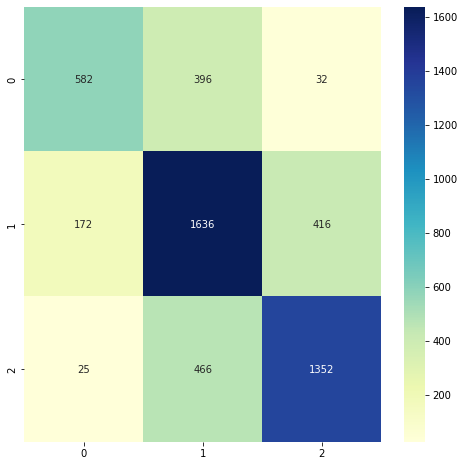

In [ ]:
# Graficamos la matriz de confusion
plt.figure(figsize= (8, 8))
ax= plt.subplot()
sns.heatmap(cm_rf, annot=True, fmt='g', ax=ax, cmap="YlGnBu");

In [ ]:
scores_rf = cross_validate(rf, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))

accuracy = scores_rf['test_accuracy']
f1_macro = scores_rf['test_f1_macro']
recall_macro = scores_rf['test_recall_macro']
precision_macro = scores_rf['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.703 +/- 0.008
f1 macro: 0.695 +/- 0.010
Recall macro: 0.682 +/- 0.011
Precision macro: 0.718 +/- 0.008


In [ ]:
rf.fit(X_train, t_train)
rf.feature_importances_

array([0.07235958, 0.09988981, 0.07908176, 0.08228709, 0.08719364,
       0.08472568, 0.08946068, 0.10404312, 0.08113786, 0.08293725,
       0.13373149, 0.00315204])

Parece que los tres features más importantes son: Alcohol (12%), Densidad (10%) y Acidez Volátil (9,9%).

Ajustemos perillas!!!

In [ ]:
rf_param = {'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400]}

grilla_rf = RandomizedSearchCV(rf,rf_param,cv=5, n_iter = 30,scoring='accuracy')
grilla_rf.fit(X_train, t_train)

In [ ]:
model_rf = grilla_rf.best_estimator_

In [ ]:
scores_rf = cross_validate(model_rf, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))


In [ ]:
rf_predic = cross_val_predict(model_rf, X_train, t_train, cv = 5)

In [ ]:
cm_rfOpt = confusion_matrix(t_train, rf_predic)
print(cm_rfOpt)

[[ 599  375   36]
 [ 173 1623  428]
 [  22  466 1355]]


In [ ]:
accuracy = scores_rf['test_accuracy']
f1_macro = scores_rf['test_f1_macro']
recall_macro = scores_rf['test_recall_macro']
precision_macro = scores_rf['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.705 +/- 0.010
f1 macro: 0.699 +/- 0.012
Recall macro: 0.686 +/- 0.013
Precision macro: 0.719 +/- 0.010


# Ensamblemos los modelos 

Voting clasifier soft:


In [ ]:
from sklearn.ensemble import VotingClassifier
voting_clf_soft = VotingClassifier(
    estimators=[('lr', lr), ('tree', dt), ('svc', svc), ('rf', rf)],
    voting='soft')

In [ ]:
voting_clf_soft.fit(X_train, t_train)
voting_predic = cross_val_predict(voting_clf_soft, X_train, t_train)

In [ ]:
cm_voting = confusion_matrix(t_train, voting_predic)
print(cm_voting)

In [ ]:
# Graficamos la matriz de confusion
plt.figure(figsize= (8, 8))
ax= plt.subplot()
sns.heatmap(cm_voting, annot=True, fmt='g', ax=ax, cmap="YlGnBu");

In [ ]:
scores_voting = cross_validate(voting_clf_soft, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))

accuracy = scores_voting['test_accuracy']
f1_macro = scores_voting['test_f1_macro']
recall_macro = scores_voting['test_recall_macro']
precision_macro = scores_voting['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Bagging:

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier

bag_clf = BaggingClassifier(model_dt, n_estimators= 100 ,
  max_samples=1.0,
  max_features=1.0,
  random_state=42,
  n_jobs=-1)
bag_clf.fit(X_train, t_train)
bag_clf_pred = cross_val_predict(bag_clf,X_train,t_train)


In [ ]:
cm_bag_clf = confusion_matrix(t_train, bag_clf_pred)
print(cm_bag_clf)

[[ 399  557   54]
 [ 205 1468  551]
 [  22  619 1202]]


In [ ]:
# Graficamos la matriz de confusion
plt.figure(figsize= (8, 8))
ax= plt.subplot()
sns.heatmap(cm_bag_clf, annot=True, fmt='g', ax=ax, cmap="YlGnBu");

In [ ]:
scores_bag_clf = cross_validate(bag_clf, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))

accuracy = scores_bag_clf['test_accuracy']
f1_macro = scores_bag_clf['test_f1_macro']
recall_macro = scores_bag_clf['test_recall_macro']
precision_macro = scores_bag_clf['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.604 +/- 0.009
f1 macro: 0.583 +/- 0.012
Recall macro: 0.569 +/- 0.011
Precision macro: 0.619 +/- 0.009


In [ ]:
params={'n_estimators':[100, 200, 300,500],
        'max_samples':[0.6, 0.8, 1.0],
        'max_features': [4, 6, 8,10, 12]}
grilla_bag_clf=GridSearchCV(bag_clf,params,cv=5,scoring='accuracy')
grilla_bag_clf.fit(X_train,t_train)
print(grilla_bag_clf.best_params_)

{'max_features': 6, 'max_samples': 1.0, 'n_estimators': 200}


In [ ]:
model_bag_clf = grilla_bag_clf.best_estimator_

In [ ]:
scores_bag_clf = cross_validate(model_bag_clf, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))


In [ ]:
bag_clf_predic = cross_val_predict(model_bag_clf, X_train, t_train, cv = 5)

In [ ]:
cm_bag_clf_opt = confusion_matrix(t_train, bag_clf_predic)
print(cm_bag_clf_opt)

[[ 308  668   34]
 [ 128 1581  515]
 [  12  639 1192]]


In [ ]:
accuracy = scores_bag_clf['test_accuracy']
f1_macro = scores_bag_clf['test_f1_macro']
recall_macro = scores_bag_clf['test_recall_macro']
precision_macro = scores_bag_clf['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.607 +/- 0.014
f1 macro: 0.569 +/- 0.015
Recall macro: 0.554 +/- 0.015
Precision macro: 0.640 +/- 0.015


Stacking:

In [ ]:
estimators = [('lr', lr), ('tree', dt), ('svc', svc), ('rf', rf)]

In [ ]:
reg = StackingRegressor(estimators=estimators, final_estimator=rf)

In [ ]:
reg_fit = reg.fit(X_train, t_train)

In [ ]:
reg_fit_pred = cross_val_predict(reg_fit,X_train,t_train)


In [ ]:
cm_reg_fit = confusion_matrix(t_train, reg_fit_pred)
print(cm_reg_fit)

[[ 399  557   54]
 [ 205 1468  551]
 [  22  619 1202]]


In [ ]:
# Graficamos la matriz de confusion
plt.figure(figsize= (8, 8))
ax= plt.subplot()
sns.heatmap(cm_reg_fit, annot=True, fmt='g', ax=ax, cmap="YlGnBu");

In [ ]:
scores_reg_fit = cross_validate(reg_fit, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))

accuracy = scores_reg_fit['test_accuracy']
f1_macro = scores_reg_fit['test_f1_macro']
recall_macro = scores_reg_fit['test_recall_macro']
precision_macro = scores_reg_fit['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.604 +/- 0.009
f1 macro: 0.583 +/- 0.012
Recall macro: 0.569 +/- 0.011
Precision macro: 0.619 +/- 0.009


# Boosting

In [47]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier


Adaboost:

In [50]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm = 'SAMME', random_state=42)

parameters = {'base_estimator__max_depth': [6,8,10,12],
              'base_estimator__min_samples_leaf':[5,10, 20, 30],
              'base_estimator__max_leaf_nodes': [10, 20, 35, 40, 45],
              'n_estimators':[10,50,250,500],
              'learning_rate':[0.01, 0.05, 0.1, 0.5]
              }

ada_gs = GridSearchCV(abc, parameters,scoring='accuracy',cv = 5, n_jobs=-1)
ada_gs.fit(X_train,t_train)


KeyboardInterrupt: ignored

In [ ]:
model_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm = 'SAMME', random_state=42, base_estimator__max_depth = 8,
                               base_estimator__max_leaf_nodes = 35,
                               base_estimator__min_samples_leaf = 10,
                               learning_rate = 0.5,
                               n_estimators = 500)

In [ ]:
ada_gs.best_estimator_

In [ ]:
model_ada = ada_gs.best_estimator_

In [ ]:
scores_ada = cross_validate(model_ada, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))


In [ ]:
ada_predic = cross_val_predict(model_ada, X_train, t_train, cv = 5)

In [ ]:
cm_adaOpt = confusion_matrix(t_train, ada_predic)
print(cm_adaOpt)

In [ ]:
accuracy = scores_ada['test_accuracy']
f1_macro = scores_ada['test_f1_macro']
recall_macro = scores_ada['test_recall_macro']
precision_macro = scores_ada['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

In [ ]:
curvas_roc_multiclase(n_clases=n_clases, nom_clases=nom_clases, true_labels=t_train, y_score=scores_ada)

GradientBoosting:

In [51]:
gbc = GradientBoostingClassifier(warm_start=True, random_state=42)
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [52]:
gbc_tune = GridSearchCV(gbc,parameters,cv=5)
gbc_tune.fit(X_train,t_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(random_state=42,
                                                  warm_start=True),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]})

In [53]:
model_gbc = gbc_tune.best_estimator_

In [54]:
scores_gbc = cross_validate(model_gbc, X_train, t_train, cv = 5, scoring = ("accuracy", "f1_macro", "recall_macro", "precision_macro"))


In [62]:
y_score_gbc_best = cross_val_predict(model_gbc, X_train, t_train, cv = 5, method = "predict_proba")

In [55]:
gbc_predic = cross_val_predict(model_gbc, X_train, t_train, cv = 5)

In [56]:
cm_gbcOpt = confusion_matrix(t_train, gbc_predic)
print(cm_gbcOpt)

[[ 578  385   47]
 [ 188 1605  431]
 [  32  468 1343]]


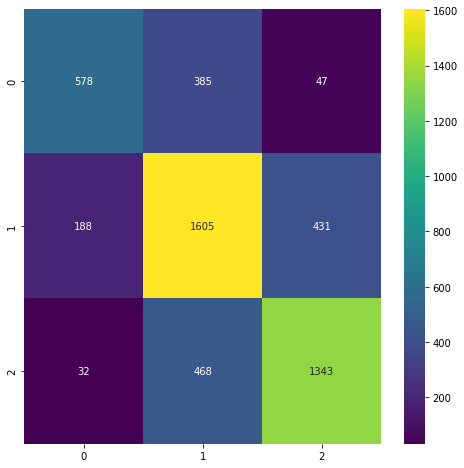

In [59]:
# Graficamos la matriz de confusion
plt.figure(figsize= (8, 8))
ax= plt.subplot()
sns.heatmap(cm_gbcOpt, annot=True, fmt='g', ax=ax, cmap="viridis");

In [57]:
accuracy = scores_gbc['test_accuracy']
f1_macro = scores_gbc['test_f1_macro']
recall_macro = scores_gbc['test_recall_macro']
precision_macro = scores_gbc['test_precision_macro']

print(f'Accuracy: {accuracy.mean():.3f} +/- {accuracy.std():.3f}')
print(f'f1 macro: {f1_macro.mean():.3f} +/- {f1_macro.std():.3f}')
print(f'Recall macro: {recall_macro.mean():.3f} +/- {recall_macro.std():.3f}')
print(f'Precision macro: {precision_macro.mean():.3f} +/- {precision_macro.std():.3f}')

Accuracy: 0.695 +/- 0.011
f1 macro: 0.686 +/- 0.013
Recall macro: 0.674 +/- 0.014
Precision macro: 0.705 +/- 0.012


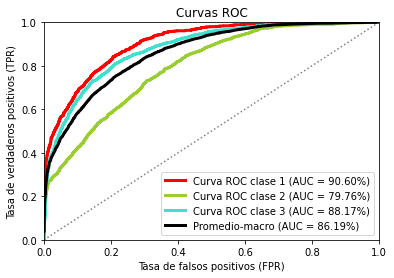

In [63]:
curvas_roc_multiclase(n_clases=n_clases, nom_clases=nom_clases, true_labels=t_train, y_score=y_score_gbc_best)

# Redes neuronales


In [166]:
import tensorflow as tf
from tensorflow import keras

In [167]:
X_validacion, X_entrenamiento = X_train[4000:] , X_train[:4001] 
t_validacion, t_entrenamiento = t_train[4000:], t_train[:4001]

In [168]:
t_validacion.value_counts()

1    446
2    391
0    240
Name: quality, dtype: int64

In [169]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [170]:
X_train.shape

(5077, 12)

In [171]:
#Definimos una capa especial, que es la entrada del modelo:
input_ = keras.layers.Input(shape=(12,))
#Luego se instancia cada capa y se aplica como una función a la salida de la capa anterior
hidden1 = keras.layers.Dense(200, activation="relu")(input_)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu")(dropout)
# hidden3 = keras.layers.Dense(50, activation="relu")(hidden2)
dropout = keras.layers.Dropout(rate=0.2)(hidden2)
hidden4 = keras.layers.Dense(25, activation="relu")(dropout)


output = keras.layers.Dense(3, activation="softmax")(hidden4)

#Cuando se haya llegado a las las salidas, podemos definir el modelo:
model = keras.models.Model(inputs=[input_], outputs=[output])

In [181]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [182]:
model.layers

In [183]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 200)               2600      
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 3)                 78    

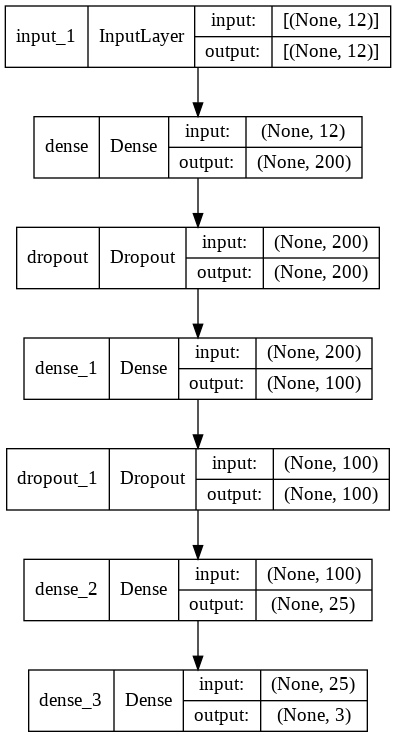

In [184]:
keras.utils.plot_model(model, "vinos_claisifacion.png", show_shapes=True)

In [185]:
t_validacion

4091    1
4092    2
4093    2
4094    1
4095    2
       ..
5192    0
5193    2
5194    2
5195    2
5196    1
Name: quality, Length: 1077, dtype: int64

In [186]:
history = model.fit(X_entrenamiento, t_entrenamiento, epochs=200, batch_size=32,
                    validation_data=(X_validacion, t_validacion))

Epoch 1/200


ValueError: ignored

In [178]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

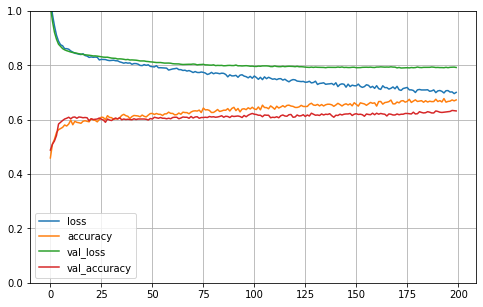

In [179]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [180]:
model.evaluate(X_validacion, t_validacion)

34/34 [==============================] - 0s 2ms/step - loss: 0.7922 - accuracy: 0.6323


[0.7922133803367615, 0.632311999797821]

# Aplicmos el mejor modelo sobre el set de testeo

In [ ]:
t_pred = model_rf.predict(X_test)

In [ ]:
accuracy_score(t_test, t_pred)

In [ ]:
f1_score(t_test, t_pred, average = "macro")

In [ ]:
print(classification_report(t_test, t_pred))

In [ ]:
cm_rf_test = confusion_matrix(t_test, t_pred)
print(cm_rf_test)